# Players Stats -- Data Cleaning and EDA
Pierre-Antoine MAHE -- June 2020

## Table of Contents

* [Introduction](#introduction)
* [Loading Data](#loading)
* [Data Points in Players DB](#datapoints)
* [Data description](#description)
* [Null Values](#null)
* [EDA](#eda)
    - [Rating 1.0 and Impact](#rating)
    - [Aggregated Variables](#aggregated)
    - [rounds_X_kill](#roundXkill)
    - [Opening kills and deaths](#openings)

## 1. Introduction <a name='introduction'></a>

## 2. Loading Data<a name="loading"></a>

In [173]:
# Data Wrangling
import numpy as np
import pandas as pd

# DB connection
import sqlite3

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.gridspec as gridspec

# Normalizer
from sklearn.preprocessing import MinMaxScaler

In [174]:
conn = sqlite3.connect('../../CSGOscraper/data/hltv.db')
players_df = pd.read_sql("""SELECT * FROM players_stats""", conn)
players_df.head()

,player_ref,player_name,rating_1,rating_2,impact,deaths_per_round,kast,average_damage_per_round,kills_per_round,total_kills,...,opening_kill_ratio,team_win_percent_after_first_kill,first_kill_in_won_rounds,rifle_kills,sniper_kills,smg_kills,pistol_kills,grenade_kills,other_kills,maps_won
0,11893,ZywOo,1.29,1.35,1.50,0.62,0.748,90.4,0.87,14311,...,1.60,0.731,0.220,5107,5306,788,2851,165,116,0.606
1,39,GeT_RiGhT,1.10,NaN,1.03,0.64,0.691,76.8,0.74,32012,...,1.08,0.762,0.140,23226,878,2125,4816,443,541,0.616
2,13281,El1an,1.10,1.13,1.19,0.64,0.689,76.3,0.74,11540,...,1.44,0.721,0.196,2077,7076,234,2025,72,70,0.458
3,5021,swag,1.10,NaN,1.09,0.62,0.729,77.6,0.73,10527,...,1.20,0.757,0.136,6649,1365,447,1847,171,69,0.606
4,1378,zehN,1.10,NaN,1.13,0.65,0.716,80.9,0.74,16421,...,1.07,0.761,0.131,11566,471,1285,2698,355,61,0.586


In [175]:
players_df.shape

(721, 39)

The dataframe shape is as expected, in the next part we will talk a bit more about the available datapoints.

## 3. Datapoints in Players DB <a name='datapoints'></a>

There are quite a few datapoints in the players statistics database, since we build the scraper we can already give a short explanation for each one.

This can also be found in the players_stats.md file (WIP)

### Player Metadata


* **player_ref** : reference number of the player on the hltv website.
* **player_name** : player's pseudonym.


* **rating_1** : a number computed by hltv "telling us if the player put up above or below average numbers, with 1.00 being the average.
* **rating_2** : improvement on rating_1 (see https://www.hltv.org/news/20695/introducing-rating-20 for details). Computed for 2016 and onward data. Cannot be computed for players with registered stats before 2016.
* **impact** : another hltv metric that measures the impact made from multikills, opening kills, and clutches.

--------------------------------------------------------------------------------

### Overall Statistics


* **maps_played** : total number of played maps recorded.
* **maps_won** : total number of recorded maps won.
* **rounds_played** : total number of played rounds recorded.
* **round_with_kills** : total number of rounds when the player had at least a kill.


* **total_kills** : total number of kills recorded.
* **total_deaths** : total number of deaths recorded.
* **kill_death_difference** : difference between **total_kills** and **total_deaths**.
* **kd_ratio** : ratio of **total_kills** and **total_deaths**.


* **rounds_X_kill**: number of rounds when the player had X (0, 1, 2, 3, 4 or 5) kills.


* **total_opening_kills** : total number of opening kills (the player was the first of all 10 players to kill an enemy during the round).
* **total_opening_deaths** : total number of opening deaths (the player was the first of all 10 players to die).
* **opening_kill_ratio** : ratio of the last two statistics.

--------------------------------------------------------------------------------

### Average Statistics


* **kills_per_round** : ratio of **total_kills** over **rounds_played**.
* **deaths_per_round** : ratio of **total_deaths** over **rounds_played**.
* **assists_per_round** : number of assists per round. To get an assist, the player need to do at least 41 damage (out of100), then the enemy needs to die. This doesn't take into account flash assists or else, only damage.


* **average_damage_per_round** : average damage dealt by the player per round.
* **grenade_damage_per_round** : average damage dealt by the player per round with grenades.
* **headshot_percent** : number of kills where the last bullet was a headshot.
* **kast** : percentage of rounds in which the player either had a kill, assist, survived or was traded.

--------------------------------------------------------------------------------

### Specific Statistics


* **team_win_percent_after_first_kill**: percentage of rounds won by the player's team after the player took the first kill
* **first_kill_in_won_rounds**: percentage of rounds where the player took the first kill and the player's team won


* **saved_by_teammate_per_round** : number of times the player has been saved by a teammate per round (to save a teammate you need to kill the attacker that was damaging an ally within 1 seconds of his last attack). Data from 2016 and onward only.
* **saved_a_teammate_per_round** : number of times the player has saved a teammate per round. Data from 2016 and onward only.

--------------------------------------------------------------------------------

### Weapon Statistics


* **weapons_kills** : numbers of kills performed with the specified weapon (rifle, sniper, smg, pistol, grenade or other).


Let's just reorder the dataframe columns so that similar statistics are close to each other (will make the work easier when looking at the correlation matrix).

In [176]:
print(players_df.shape)

reordered_columns = ['player_ref', 'player_name', 'rating_1', 'rating_2', 'impact', 'maps_played', 'maps_won',
                    'rounds_played', 'rounds_with_kills', 'total_kills', 'total_deaths', 'kill_death_difference',
                    'kd_ratio', 'rounds_0_kill', 'rounds_1_kill', 'rounds_2_kill', 'rounds_3_kill', 
                    'rounds_4_kill', 'rounds_5_kill', 'total_opening_kills', 'total_opening_deaths',
                    'opening_kill_ratio', 'kills_per_round', 'deaths_per_round', 'assists_per_round',
                    'average_damage_per_round', 'grenade_damage_per_round', 'headshot_percent', 'kast',
                    'team_win_percent_after_first_kill', 'first_kill_in_won_rounds',
                    'saved_by_teammate_per_round', 'saved_a_teammate_per_round', 'rifle_kills', 'sniper_kills',
                    'smg_kills', 'pistol_kills', 'grenade_kills', 'other_kills']

players_df = players_df[reordered_columns]

print(players_df.shape)

(721, 39)
(721, 39)


## 4. Data description <a name='description'></a>

Verifying that the datapoints types are similar to what was present in the SQL database.

In [177]:
players_df.dtypes

player_ref                            object
player_name                           object
rating_1                             float64
rating_2                             float64
impact                               float64
maps_played                            int64
maps_won                             float64
rounds_played                          int64
rounds_with_kills                      int64
total_kills                            int64
total_deaths                           int64
kill_death_difference                  int64
kd_ratio                             float64
rounds_0_kill                          int64
rounds_1_kill                          int64
rounds_2_kill                          int64
rounds_3_kill                          int64
rounds_4_kill                          int64
rounds_5_kill                          int64
total_opening_kills                    int64
total_opening_deaths                   int64
opening_kill_ratio                   float64
kills_per_

In [178]:
players_df.describe()

,rating_1,rating_2,impact,maps_played,maps_won,rounds_played,rounds_with_kills,total_kills,total_deaths,kill_death_difference,...,team_win_percent_after_first_kill,first_kill_in_won_rounds,saved_by_teammate_per_round,saved_a_teammate_per_round,rifle_kills,sniper_kills,smg_kills,pistol_kills,grenade_kills,other_kills
count,721.000000,227.000000,720.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,...,721.000000,721.000000,720.000000,720.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000
mean,1.014674,1.080925,1.061556,685.547850,0.538828,17891.839112,8426.669903,12460.791956,11938.296810,522.495146,...,0.735305,0.146975,0.096528,0.097278,7662.865465,1674.026352,714.080444,2213.313454,155.564494,60.638003
std,0.069346,0.064981,0.107689,346.945218,0.059755,9089.682042,4350.639031,6501.890991,6008.779949,1252.289998,...,0.020790,0.026901,0.011045,0.013283,4679.535372,2644.784919,420.768591,1155.272656,104.885197,75.136399
min,0.770000,0.840000,0.470000,300.000000,0.367000,7551.000000,3043.000000,4192.000000,5051.000000,-6238.000000,...,0.670000,0.069000,0.060000,0.070000,1051.000000,7.000000,105.000000,700.000000,27.000000,2.000000
25%,0.970000,1.040000,1.000000,405.000000,0.498000,10589.000000,4895.000000,7184.000000,7221.000000,-204.000000,...,0.722000,0.129000,0.090000,0.090000,4296.000000,166.000000,403.000000,1301.000000,79.000000,20.000000
50%,1.010000,1.080000,1.060000,600.000000,0.541000,15666.000000,7330.000000,10679.000000,10311.000000,318.000000,...,0.735000,0.144000,0.100000,0.100000,6401.000000,481.000000,615.000000,1899.000000,125.000000,39.000000
75%,1.060000,1.120000,1.130000,847.000000,0.578000,22000.000000,10411.000000,15196.000000,14676.000000,1101.000000,...,0.749000,0.164000,0.100000,0.110000,9837.000000,1913.000000,934.000000,2733.000000,195.000000,72.000000
max,1.290000,1.350000,1.500000,1844.000000,0.745000,48228.000000,22663.000000,34339.000000,32342.000000,6283.000000,...,0.819000,0.264000,0.130000,0.140000,24335.000000,17977.000000,2615.000000,6934.000000,839.000000,961.000000


First obvious observation : <p>**rating_2 as only 227 values**. This is explained above, rating_2 can't be accurately computed for players with recorded stats before 2016. It was scraped to be thorough but **we can drop it** for our analysis.

In [179]:
players_df.drop('rating_2', axis=1, inplace=True)

## 5. Null Values <a name='null'></a>

We can also see that some columns have 720 values out of 721. This shows the existence of some NULL values.

In [180]:
players_df.isnull().sum()

player_ref                           0
player_name                          0
rating_1                             0
impact                               1
maps_played                          0
maps_won                             0
rounds_played                        0
rounds_with_kills                    0
total_kills                          0
total_deaths                         0
kill_death_difference                0
kd_ratio                             0
rounds_0_kill                        0
rounds_1_kill                        0
rounds_2_kill                        0
rounds_3_kill                        0
rounds_4_kill                        0
rounds_5_kill                        0
total_opening_kills                  0
total_opening_deaths                 0
opening_kill_ratio                   0
kills_per_round                      0
deaths_per_round                     0
assists_per_round                    0
average_damage_per_round             1
grenade_damage_per_round 

In [181]:
players_df[players_df.isnull().any(axis=1)]

,player_ref,player_name,rating_1,impact,maps_played,maps_won,rounds_played,rounds_with_kills,total_kills,total_deaths,...,team_win_percent_after_first_kill,first_kill_in_won_rounds,saved_by_teammate_per_round,saved_a_teammate_per_round,rifle_kills,sniper_kills,smg_kills,pistol_kills,grenade_kills,other_kills
120,7147,Fifflaren,0.94,NaN,537,0.745,13195,5650,7873,7916,...,0.819,0.132,NaN,NaN,4741,1355,187,1386,188,16


**Only one row** contains NULL values, for a player called Fifflaren. That makes sense as he didn't played profesionaly since 2014 (<https://www.hltv.org/player/7147/Fifflaren#tab-matchesBox>).

In [182]:
players_df.drop(120, inplace=True)
players_df.reset_index(drop=True, inplace=True)

In [183]:
players_df[players_df.isnull().any(axis=1)]

,player_ref,player_name,rating_1,impact,maps_played,maps_won,rounds_played,rounds_with_kills,total_kills,total_deaths,...,team_win_percent_after_first_kill,first_kill_in_won_rounds,saved_by_teammate_per_round,saved_a_teammate_per_round,rifle_kills,sniper_kills,smg_kills,pistol_kills,grenade_kills,other_kills


## 6. Exploratory Data Analysis <a name='eda'></a>

In [184]:
players_df.columns

Index(['player_ref', 'player_name', 'rating_1', 'impact', 'maps_played',
       'maps_won', 'rounds_played', 'rounds_with_kills', 'total_kills',
       'total_deaths', 'kill_death_difference', 'kd_ratio', 'rounds_0_kill',
       'rounds_1_kill', 'rounds_2_kill', 'rounds_3_kill', 'rounds_4_kill',
       'rounds_5_kill', 'total_opening_kills', 'total_opening_deaths',
       'opening_kill_ratio', 'kills_per_round', 'deaths_per_round',
       'assists_per_round', 'average_damage_per_round',
       'grenade_damage_per_round', 'headshot_percent', 'kast',
       'team_win_percent_after_first_kill', 'first_kill_in_won_rounds',
       'saved_by_teammate_per_round', 'saved_a_teammate_per_round',
       'rifle_kills', 'sniper_kills', 'smg_kills', 'pistol_kills',
       'grenade_kills', 'other_kills'],
      dtype='object')

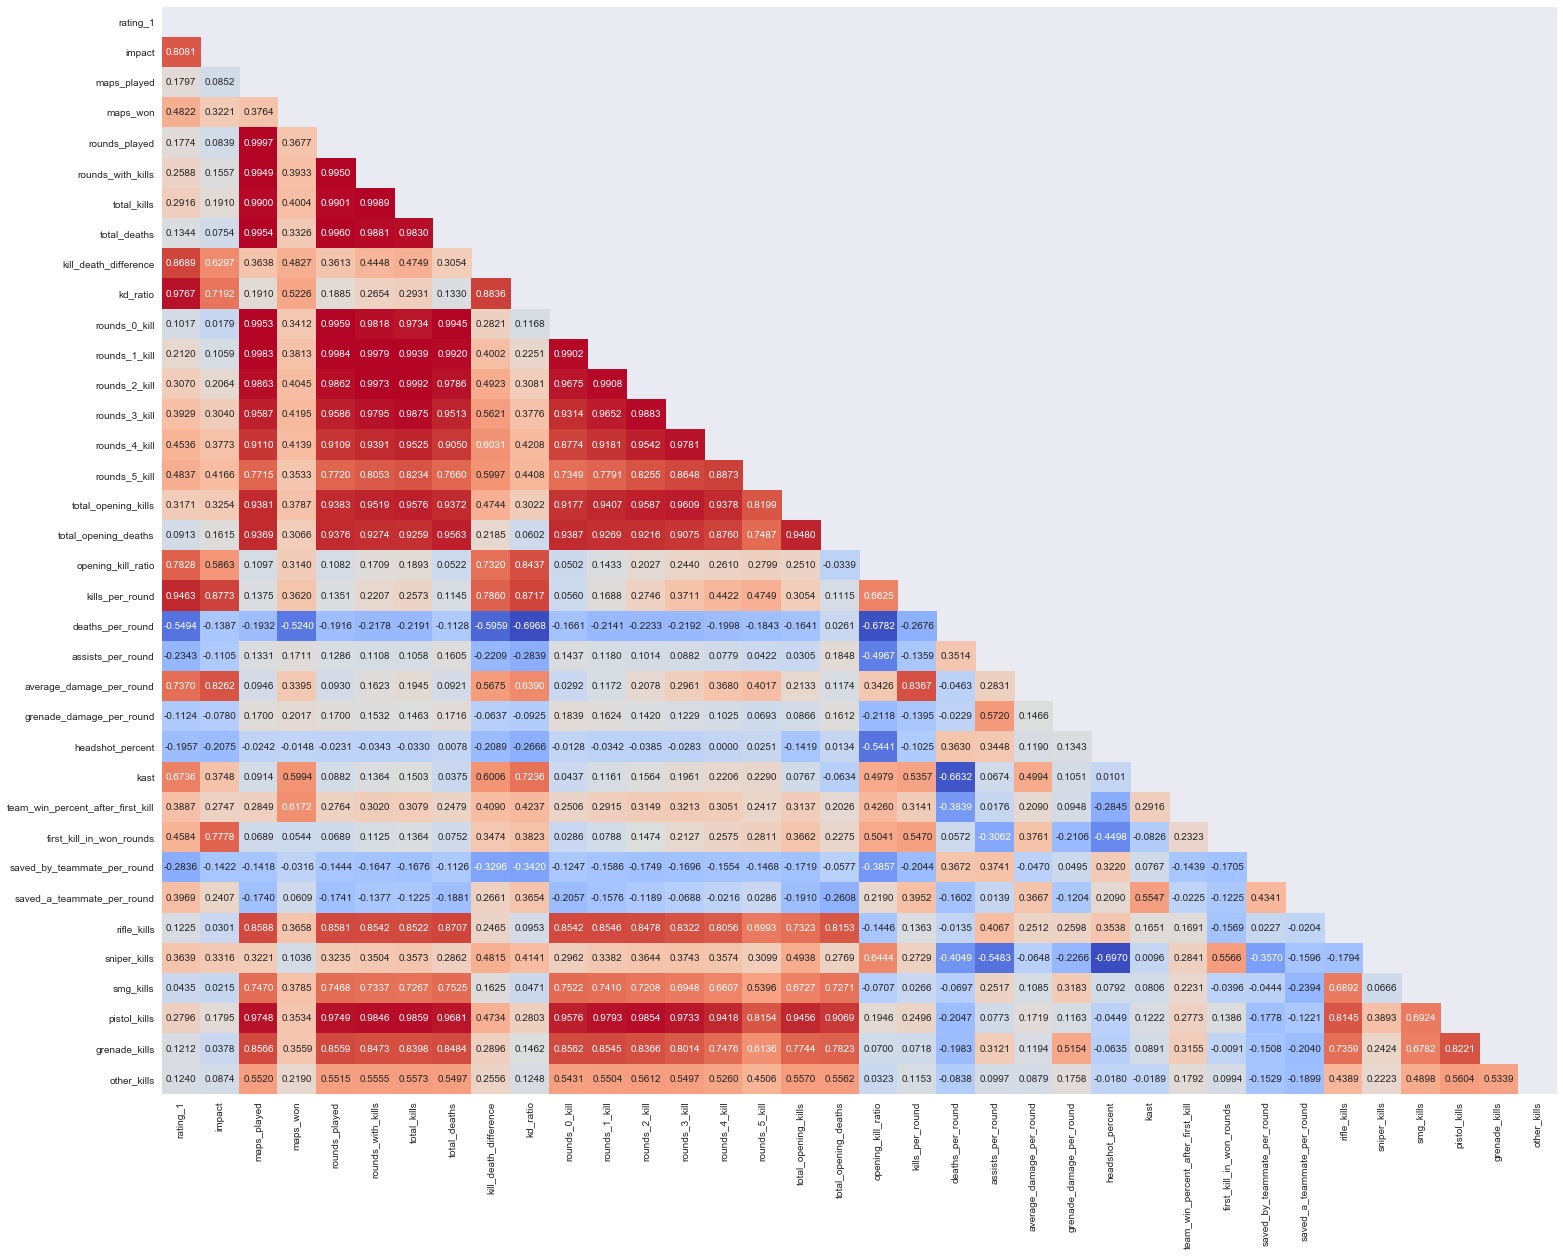

In [185]:
corr = players_df.corr(method='pearson')
mask = np.triu(corr)


fig, ax = plt.subplots(figsize=(25,20))
sns.heatmap(corr, mask=mask, annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)

ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig('pictures/players_stats_corrmatrix_1.png', bbox_inches='tight', pad_inches=0.0)

### Rating 1.0 and Impact <a name='rating'></a>

Our first observation is that **rating_1** is higly correlated to **kill_death_difference**, **kd_ratio** and **kills__per_round**. This makes sense, even the HLTV website explain that the rating 1.0 was insufficient because to close to kill-death ratio, and introduced rating 2.0.

But it's actually worse than just an outdated variable. We had hoped that **rating_1** could be used as a **ground truth** to evaluate a player quality, but it is pretty much useless as explain in the following article :

<https://chrissardegna.com/blog/problems-with-csgo-rating-systems/>

And shown in the correlation matrix above.

Therefore, **rating_1** and **impact** will not be used in our analysis.

### Aggregated Variables <a name='aggregated'></a>

By looking at the correlation matrix, we can quickly identify high correlation "blocks", they are are not true correlations but a consequence of the data collection. They are all aggregated values, increasing each time a player take part into a match (like total_kills).

We have to turn them into averaged data in order to extract meaningfull insight from the correlation matrix.

In [186]:
# Saving current dataframe as a backup
players_df.to_csv('../../data/all_players_stats.csv')

prep_df = players_df.copy()

prep_df['rounds_with_kills'] = prep_df['rounds_with_kills'] / prep_df['rounds_played']

prep_df['rounds_0_kill'] = prep_df['rounds_0_kill'] / prep_df['rounds_played']
prep_df['rounds_1_kill'] = prep_df['rounds_1_kill'] / prep_df['rounds_played']
prep_df['rounds_2_kill'] = prep_df['rounds_2_kill'] / prep_df['rounds_played']
prep_df['rounds_3_kill'] = prep_df['rounds_3_kill'] / prep_df['rounds_played']
prep_df['rounds_4_kill'] = prep_df['rounds_4_kill'] / prep_df['rounds_played']
prep_df['rounds_5_kill'] = prep_df['rounds_5_kill'] / prep_df['rounds_played']

# Total opening kills and deaths need to be put in regards to the number of rounds played
# As one or the other can only happens one time per round
prep_df['total_opening_kills']  = prep_df['total_opening_kills']  / prep_df['rounds_played']
prep_df['total_opening_deaths'] = prep_df['total_opening_deaths'] / prep_df['rounds_played']

prep_df.rename(columns={"total_opening_kills":"opening_kills_per_round", 
                        "total_opening_deaths":"opening_deaths_per_round"}, inplace=True)

prep_df['rifle_kills']   = prep_df['rifle_kills']   / prep_df['total_kills']
prep_df['sniper_kills']  = prep_df['sniper_kills']  / prep_df['total_kills']
prep_df['smg_kills']     = prep_df['smg_kills']     / prep_df['total_kills']
prep_df['pistol_kills']  = prep_df['pistol_kills']  / prep_df['total_kills']
prep_df['grenade_kills'] = prep_df['grenade_kills'] / prep_df['total_kills']
prep_df['other_kills']   = prep_df['other_kills']   / prep_df['total_kills']

In [187]:
prep_df.columns

Index(['player_ref', 'player_name', 'rating_1', 'impact', 'maps_played',
       'maps_won', 'rounds_played', 'rounds_with_kills', 'total_kills',
       'total_deaths', 'kill_death_difference', 'kd_ratio', 'rounds_0_kill',
       'rounds_1_kill', 'rounds_2_kill', 'rounds_3_kill', 'rounds_4_kill',
       'rounds_5_kill', 'opening_kills_per_round', 'opening_deaths_per_round',
       'opening_kill_ratio', 'kills_per_round', 'deaths_per_round',
       'assists_per_round', 'average_damage_per_round',
       'grenade_damage_per_round', 'headshot_percent', 'kast',
       'team_win_percent_after_first_kill', 'first_kill_in_won_rounds',
       'saved_by_teammate_per_round', 'saved_a_teammate_per_round',
       'rifle_kills', 'sniper_kills', 'smg_kills', 'pistol_kills',
       'grenade_kills', 'other_kills'],
      dtype='object')

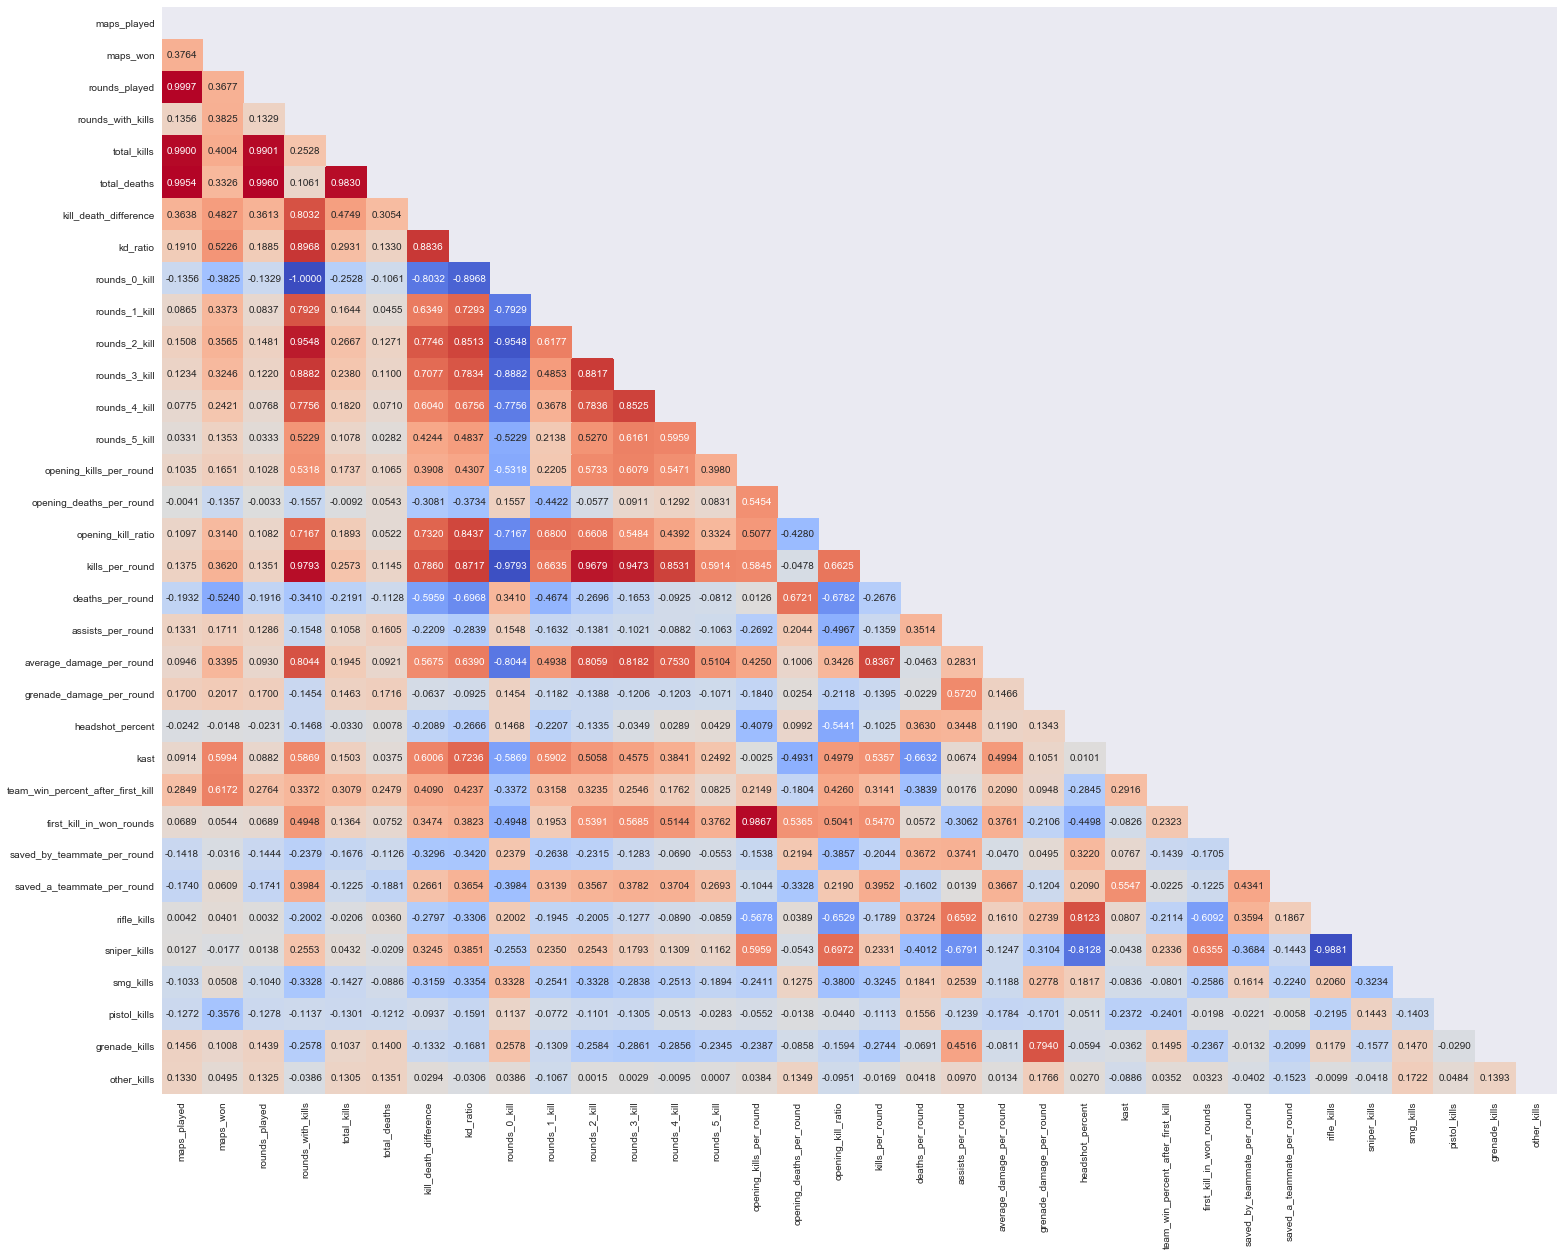

In [188]:
# don't show rating_1 and impact
corr = prep_df.iloc[:,4:].corr(method='pearson')
mask = np.triu(corr)


fig, ax = plt.subplots(figsize=(25,20))
sns.heatmap(corr, mask=mask, annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)

ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig('pictures/players_stats_corrmatrix_2.png', bbox_inches='tight', pad_inches=0.0)

The remaining aggregated variables can now be dropped (as well as rating_1 and impact) :
- maps_played
- rounds_played
- total_kills
- total_deaths
- kill_death_difference

The following plots are showing the **kill_death_difference** as a function of the **kd_ratio**.

<Figure size 432x288 with 0 Axes>

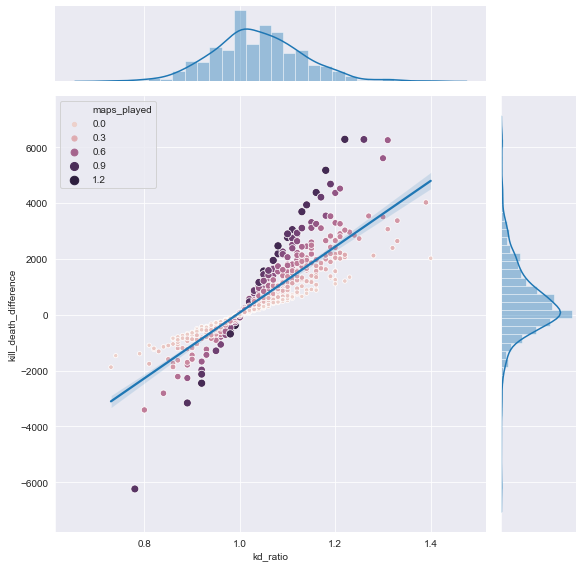

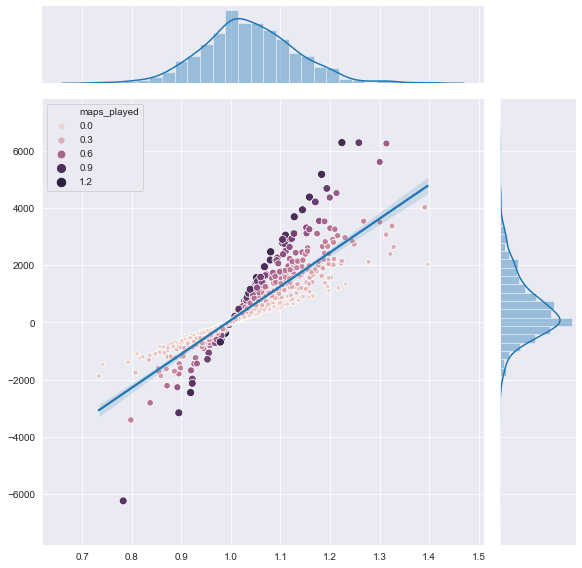

In [189]:
fig = plt.figure()

cmap = prep_df['maps_played'] / prep_df['maps_played'].max()

grid = sns.JointGrid(prep_df['kd_ratio'], prep_df['kill_death_difference'], height=8)
grid.plot_joint(sns.scatterplot, color='g', hue=cmap, size=cmap)
grid.plot_joint(sns.regplot, scatter=False)
grid.plot_marginals(sns.distplot)

plt.savefig('pictures/kd_ratio_jointgrid.png', bbox_inches='tight', pad_inches=0.0)

subs = []
ratio = []
for row in prep_df.itertuples():
    true_diff = row.total_kills - row.total_deaths
    true_div = row.total_kills / row.total_deaths
    subs.append(true_diff)
    ratio.append(true_div)
    
grid = sns.JointGrid(ratio, subs, height=8)
grid.plot_joint(sns.scatterplot, hue=cmap, size=cmap)
grid.plot_joint(sns.regplot, scatter=False)
grid.plot_marginals(sns.distplot)

Those two plots show the correlation between **kill_death_difference** and **kd_ratio**. As they are both computed from **total_kills** and **total_deaths**, the high correlation coefficient p = 0.8836 is expected. 

The divergence of players below and above kd_ratio = 1 is showing the difference in experience between players. As the player recorded matches increase, he need his **total_kills** stat to increase faster than **total_deaths** to keep the same **kd_ratio**. 

We can drop **kill_death_difference** as **kd_ratio** convey the same information. We will keep the **maps_played** column as it is a good way to measure a player experience.

The second plot is only drawn to prove that the points vertical alignement in the first one are an artefact from the rounding of the kd-ratio.

In [190]:
# Dropping aggregated variable
prep_df.drop(['rating_1', 'impact', 'rounds_played', 'total_kills', 
                'total_deaths', 'kill_death_difference'], inplace=True, axis=1)
prep_df.describe(include='all')

,player_ref,player_name,maps_played,maps_won,rounds_with_kills,kd_ratio,rounds_0_kill,rounds_1_kill,rounds_2_kill,rounds_3_kill,...,team_win_percent_after_first_kill,first_kill_in_won_rounds,saved_by_teammate_per_round,saved_a_teammate_per_round,rifle_kills,sniper_kills,smg_kills,pistol_kills,grenade_kills,other_kills
count,720,720,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,...,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
unique,720,719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,9289,steel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,685.754167,0.538542,0.469527,1.037458,0.530473,0.300041,0.124247,0.037197,...,0.735189,0.146996,0.096528,0.097278,0.616810,0.130360,0.058996,0.178666,0.012263,0.004603
std,NaN,NaN,347.142140,0.059300,0.022171,0.093942,0.022171,0.008160,0.009929,0.005403,...,0.020569,0.026914,0.011045,0.013283,0.171564,0.175315,0.022324,0.015379,0.003918,0.003905
min,NaN,NaN,300.000000,0.367000,0.377403,0.730000,0.458553,0.263798,0.088537,0.018634,...,0.670000,0.069000,0.060000,0.070000,0.084654,0.000736,0.011295,0.139859,0.004540,0.000279
25%,NaN,NaN,405.000000,0.497750,0.456630,0.980000,0.516155,0.294858,0.117888,0.033863,...,0.721750,0.129000,0.090000,0.090000,0.593141,0.016884,0.043522,0.168164,0.009468,0.002236
50%,NaN,NaN,601.000000,0.541000,0.470293,1.030000,0.529707,0.300671,0.124758,0.037233,...,0.735000,0.144000,0.100000,0.100000,0.688354,0.045449,0.056971,0.176765,0.011763,0.003472
75%,NaN,NaN,847.000000,0.577250,0.483845,1.100000,0.543370,0.305371,0.130706,0.040720,...,0.749000,0.164000,0.100000,0.110000,0.729556,0.137538,0.072326,0.187315,0.014319,0.005740


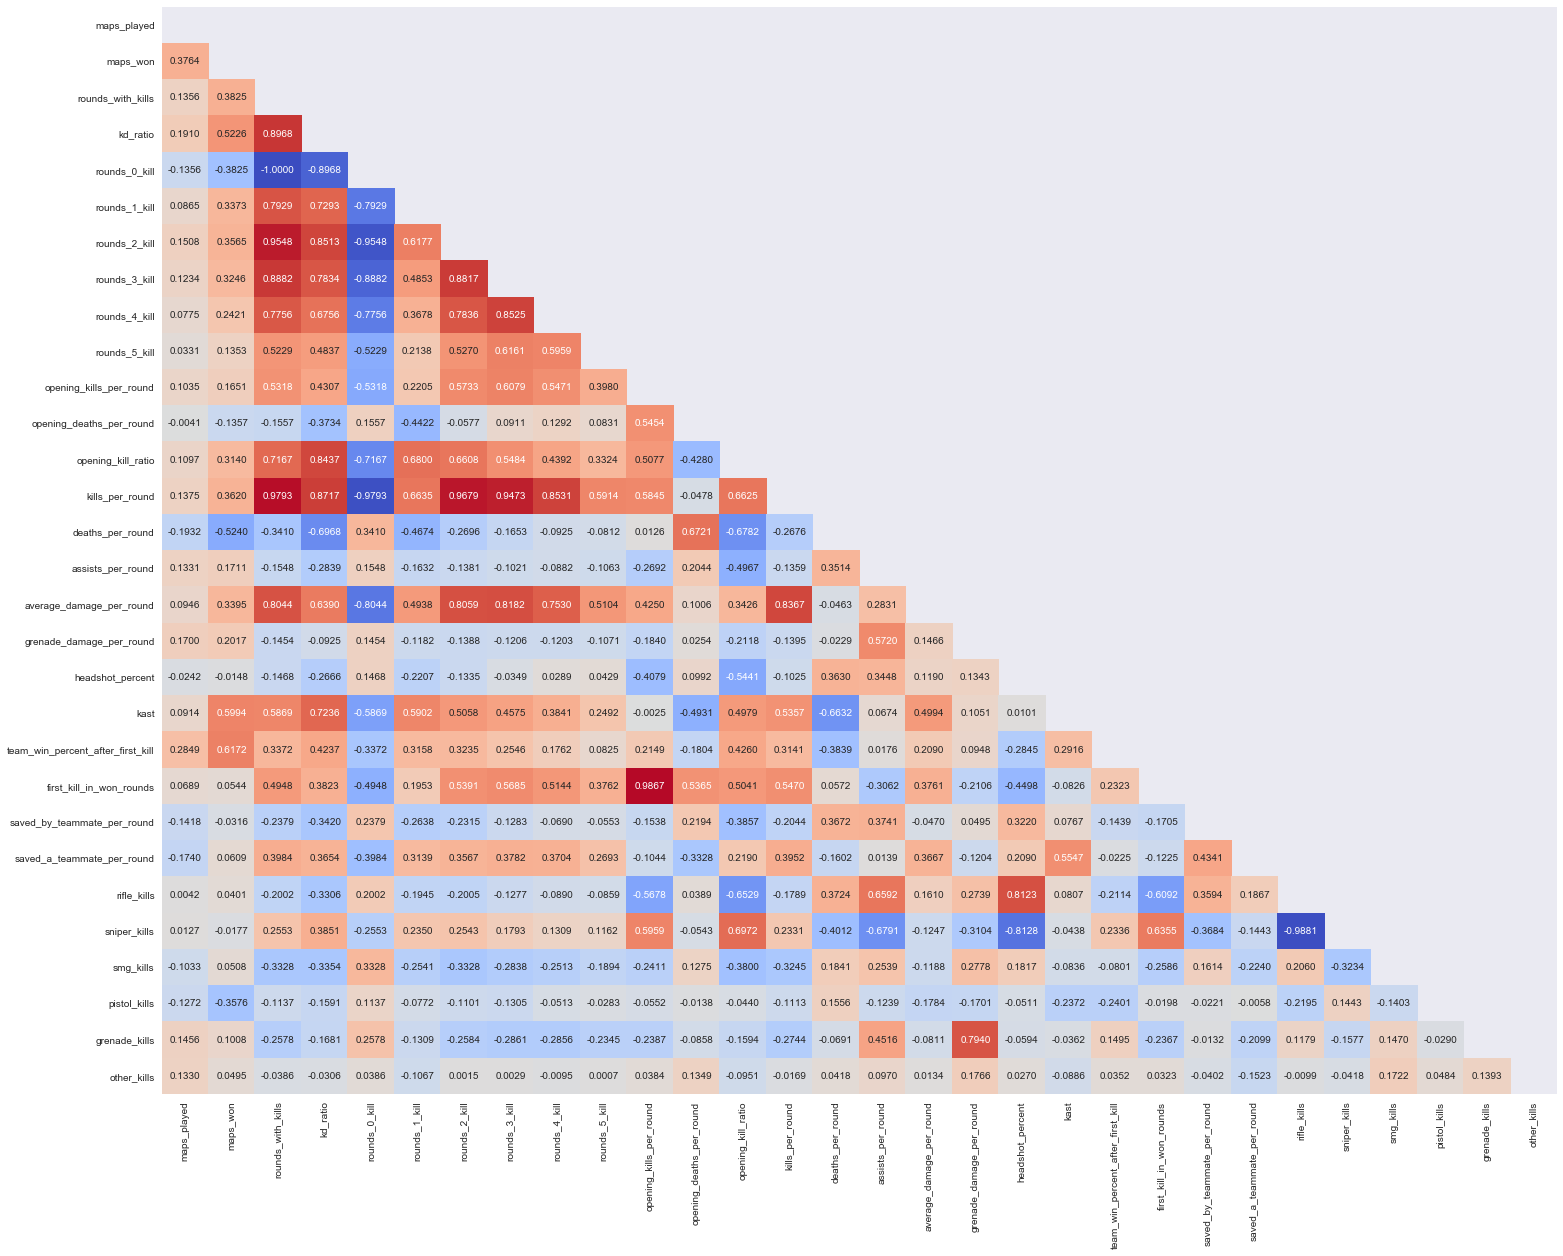

In [191]:
# If we replot the correlation matrix :
corr = prep_df.corr(method='pearson')
mask = np.triu(corr)


fig, ax = plt.subplots(figsize=(25,20))
sns.heatmap(corr, mask=mask, annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)

ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig('pictures/players_stats_corrmatrix_3.png', bbox_inches='tight', pad_inches=0.0)

Now that we averaged the data in all columns, there is no high correlation between them and the **maps_played** values. This tend to show that the player experience as a professional doesn't really impact his statistics.

### rounds_X_kill <a name='roundXkill'></a>

In [192]:
prep_df[['rounds_0_kill', 'rounds_1_kill', 'rounds_2_kill', 'rounds_3_kill', 'rounds_4_kill', 'rounds_5_kill']]

,rounds_0_kill,rounds_1_kill,rounds_2_kill,rounds_3_kill,rounds_4_kill,rounds_5_kill
0,0.462013,0.305045,0.157936,0.058432,0.013429,0.003145
1,0.506490,0.306188,0.137142,0.041008,0.008127,0.001045
2,0.504336,0.311709,0.131608,0.043612,0.008221,0.000514
3,0.510556,0.308853,0.132553,0.039039,0.008445,0.000554
4,0.515416,0.298015,0.131656,0.043210,0.010352,0.001350
...,...,...,...,...,...,...
715,0.478150,0.321276,0.143644,0.046111,0.009841,0.000978
716,0.473894,0.299612,0.156084,0.055735,0.013241,0.001435
717,0.489275,0.303254,0.146080,0.049926,0.010355,0.001109
718,0.485031,0.316921,0.141573,0.046167,0.008554,0.001755


In [193]:
prep_df[['rounds_0_kill', 'rounds_1_kill', 'rounds_2_kill', 'rounds_3_kill', 'rounds_4_kill', 'rounds_5_kill']].describe()

,rounds_0_kill,rounds_1_kill,rounds_2_kill,rounds_3_kill,rounds_4_kill,rounds_5_kill
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,0.530473,0.300041,0.124247,0.037197,0.007277,0.000765
std,0.022171,0.008160,0.009929,0.005403,0.001614,0.000325
min,0.458553,0.263798,0.088537,0.018634,0.002915,0.000000
25%,0.516155,0.294858,0.117888,0.033863,0.006212,0.000539
50%,0.529707,0.300671,0.124758,0.037233,0.007229,0.000733
75%,0.543370,0.305371,0.130706,0.040720,0.008230,0.000950
max,0.622597,0.326811,0.159081,0.058432,0.013429,0.003145


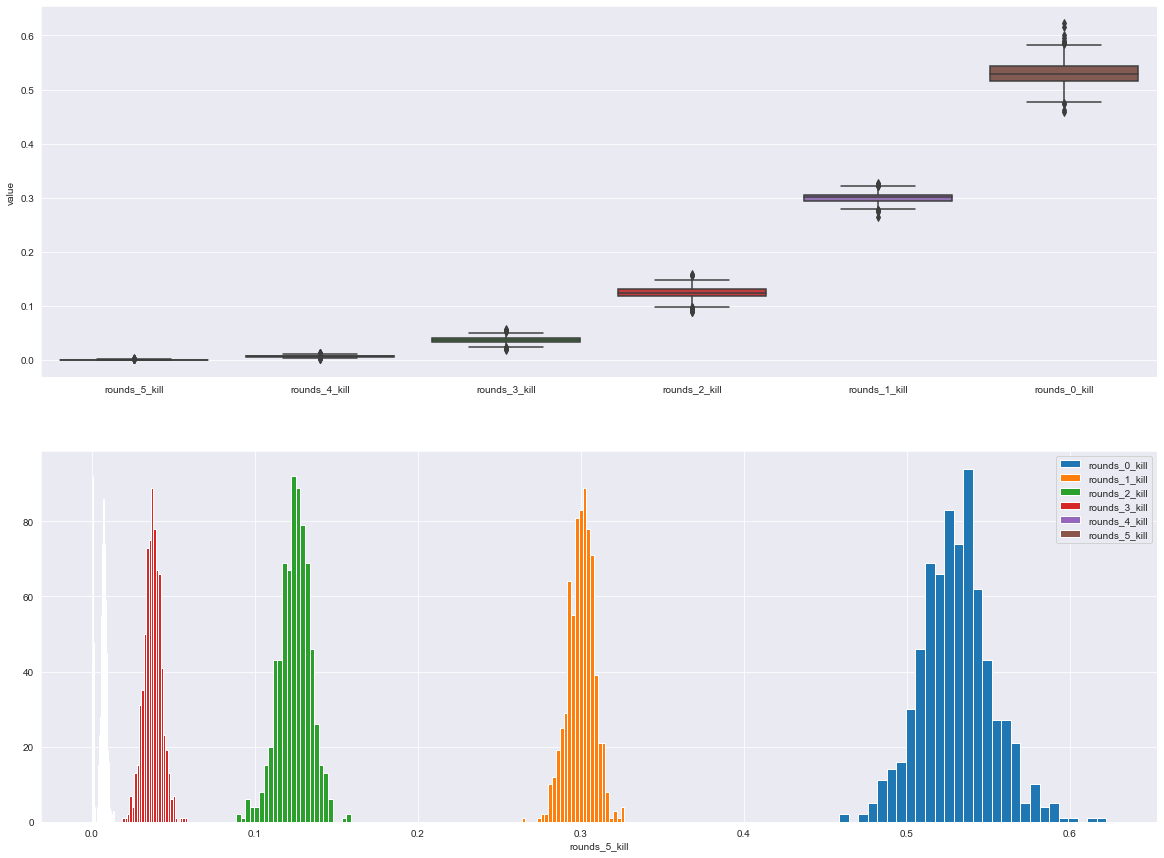

In [216]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(211)
sns.boxplot(x='variable', y='value', data=pd.melt(prep_df[['rounds_5_kill', 'rounds_4_kill', 'rounds_3_kill',
                                                         'rounds_2_kill', 'rounds_1_kill', 'rounds_0_kill']]))
ax1.set_xlabel('')

ax2 = fig.add_subplot(212)
sns.distplot(prep_df['rounds_0_kill'], label='rounds_0_kill', kde=False, hist_kws = {'alpha':1})
sns.distplot(prep_df['rounds_1_kill'], label='rounds_1_kill', kde=False, hist_kws = {'alpha':1})
sns.distplot(prep_df['rounds_2_kill'], label='rounds_2_kill', kde=False, hist_kws = {'alpha':1})
sns.distplot(prep_df['rounds_3_kill'], label='rounds_3_kill', kde=False, hist_kws = {'alpha':1})
sns.distplot(prep_df['rounds_4_kill'], label='rounds_4_kill', kde=False, hist_kws = {'alpha':1})
sns.distplot(prep_df['rounds_5_kill'], label='rounds_5_kill', kde=False, hist_kws = {'alpha':1})


ax2.legend()
plt.savefig('pictures/rounds_X_kills.png', bbox_inches='tight', pad_inches=0.0)

This barplot shows what every CS:GO player knows, multiple kills rounds (especially aces or 5 kills rounds) are rare.

But the mean percentage of rounds with 0 kills for player is 53%, way more than expected.

One last question about those datapoints : How do they change with the player experience ?

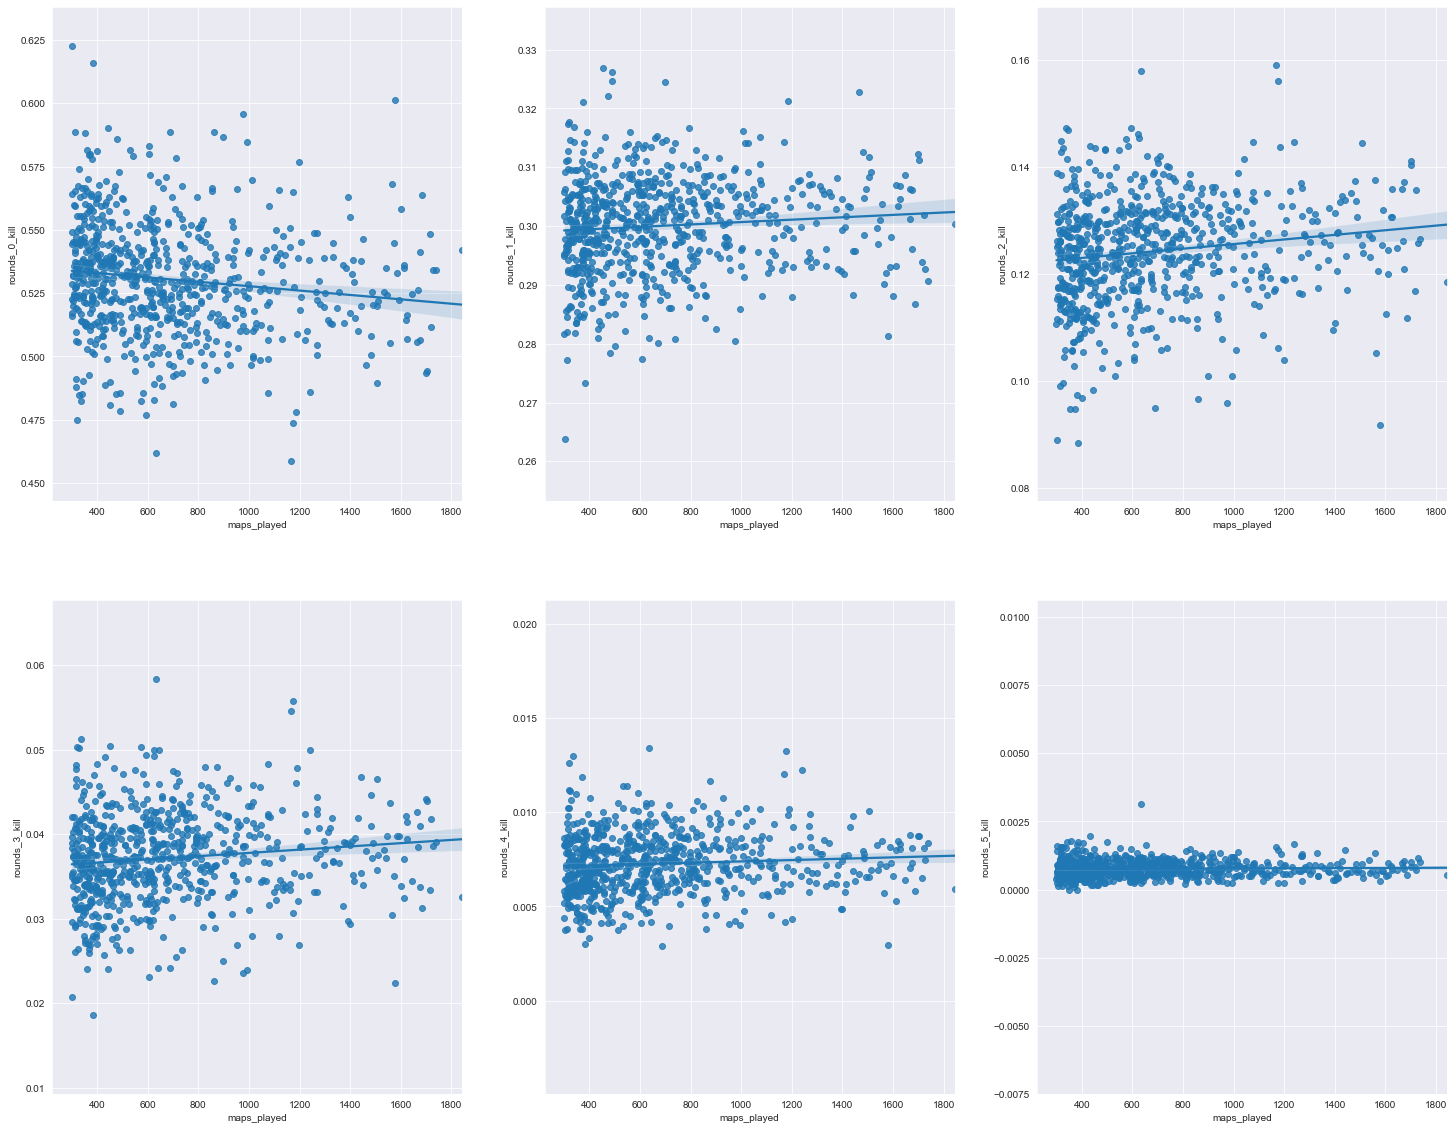

In [213]:
fig = plt.figure(figsize=(25,20))

ax = fig.add_subplot(231)
sns.regplot(prep_df['maps_played'], prep_df['rounds_0_kill'])

ax = fig.add_subplot(232)
sns.regplot(prep_df['maps_played'], prep_df['rounds_1_kill'])

ax = fig.add_subplot(233)
sns.regplot(prep_df['maps_played'], prep_df['rounds_2_kill'])

ax = fig.add_subplot(234)
sns.regplot(prep_df['maps_played'], prep_df['rounds_3_kill'])

ax = fig.add_subplot(235)
sns.regplot(prep_df['maps_played'], prep_df['rounds_4_kill'])

ax = fig.add_subplot(236)
sns.regplot(prep_df['maps_played'], prep_df['rounds_5_kill'])

Even if it is far from obvious (and dispersion is high), it seems that player with more experience tend to get kills more regularly than less experienced ones.

It also looks like rounds with 5 kills are way less correlated with the player experience than the other values. 5 rounds kills are more of a rare opportunity than a skill metrics.

### Opening kills and deaths <a name="openings"></a>

Two datapoints representing the percentage of rounds where the player killed the first enemy or was the first to die.

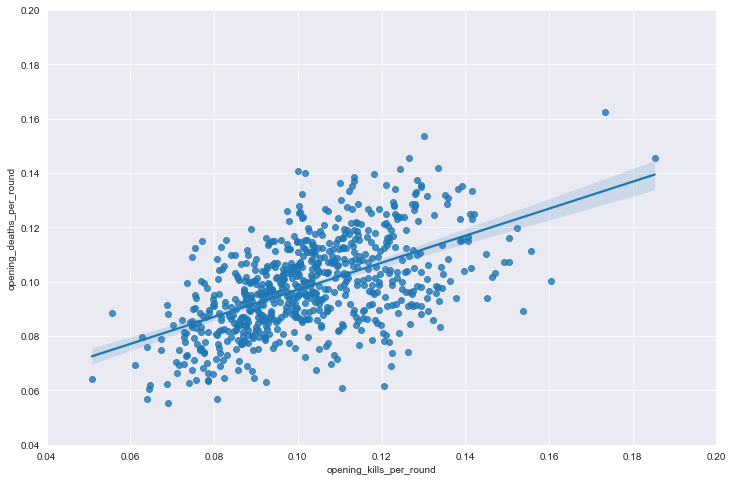

In [215]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_ylim([0.04, 0.20])
ax.set_xlim([0.04, 0.20])
sns.regplot(x="opening_kills_per_round", y="opening_deaths_per_round", data=prep_df)

It seems that both variables are following the same evolution, with opening_kills_per_round increasing a bit faster.

The sum **opening_death_per_round + opening_kills_per_round** could be a good indicator of how often a player take the first peak, and the more they do it, the (slightly) higher chance they have to win the first duel.

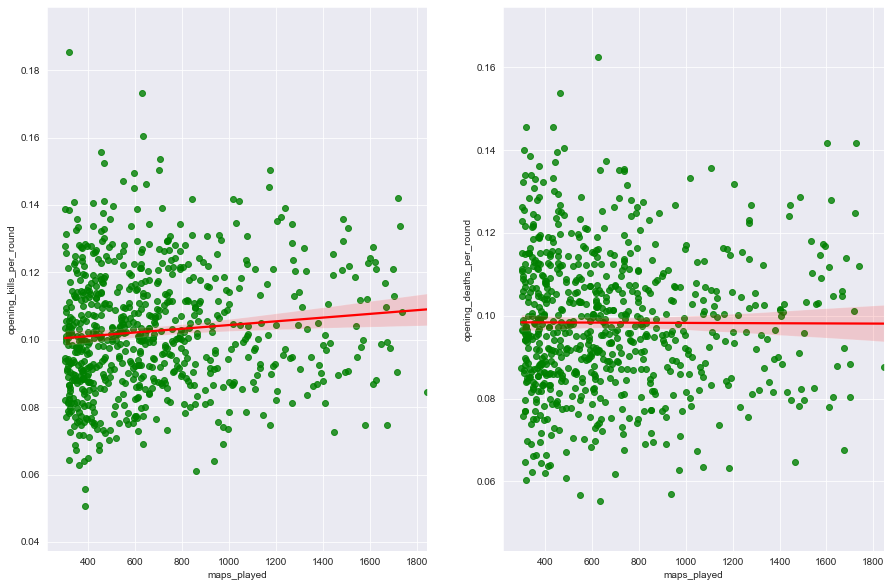

In [211]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121)
sns.regplot(x="maps_played", y="opening_kills_per_round", data=prep_df, scatter_kws={'color':'green'}, line_kws={'color':'red'})
ax = fig.add_subplot(122)
sns.regplot(x="maps_played", y="opening_deaths_per_round", data=prep_df, scatter_kws={'color':'green'}, line_kws={'color':'red'})

Once again the dispersion is high, all we can say from those two graphs is that the player experience doesn't matter that much when it comes to opening kills and deaths, with opening kills being on a slight increase trend and opening deaths a slight decrease one.

As the maps_played increase from 400 to 1800, the two percentages are varying by (at most, within the 95% confidence interval) 1%.